In [1]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import neuraltda.plotting as tpplt
import neuraltda.spikeutils as su
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

# Setup figure save path
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

Bad key "nbagg.transparent" on line 426 in
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distr

/home/brad/DailyLog/20200604/


In [2]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

# Binning Parameters
windt = 10.0                      # milliseconds
dtovr = 0.0*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'ForBettiCurvesTME'        # BootStrap Populations
bdfs = {}                         # Dictionary to store bdf

# Betti Parameters
analysis_id = 'BC'                # Generic lable
nperms = None                     # No permutation for each trial
ncellsperm = 33                   # Subsample 33 neurons from the population
dims = [0, 1, 2, 3,4,5,6,7,8,9,10]               # We want first four betti numbers
thresh = 4.0                     # Activation threshold
twin = np.linspace(0, 6000, 1000) # milliseconds

In [3]:
# Loop through each bird in our list and bin the data
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-0.0_seg-0-0-ForBettiCurvesTME/20200603T194944Z-10.0-0.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-0.0_seg-0-0-ForBettiCurvesTME/20200603T194952Z-10.0-0.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-0.0_seg-0-0-ForBettiCurvesTME/20200603T195003Z-10.0-0.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-0.0_seg-0-0-ForBettiCurvesTME/20200603T195011Z-10.0-0.0.binned


In [4]:
# Choose which bird we want to plot and pull paths to data and binned data
bird = 'B1083'
bdf = bdfs[bird]
block_path = bps[bird]

tme_shuffled_bdf = '/home/brad/krista/B1083/P03S03/tme_shuffled.binned'

In [5]:
# Break TME-shuffled into smaller chunks
import h5py as h5
ncells_subpop = 15
n_subpop = 10
block_path = bps['B1083']
bdf = bdfs['B1083']
ncells = 101 
subpop_f_files = []
subpop_f_shuff_files = []
with h5.File(tme_shuffled_bdf, 'r') as f_shuff:
    with h5.File(bdf, 'r') as f:
        for subpop_index in range(n_subpop):
            subpop_f_name = os.path.join(block_path, 'subpop_f_{}.binned'.format(subpop_index))
            subpop_f_shuff_name = os.path.join(block_path, 'subpop_f_shuff_{}.binned'.format(subpop_index))
            print(subpop_f_name)
            print(subpop_f_shuff_name)
            subpop_f = h5.File(subpop_f_name, 'w')
            subpop_f_shuff = h5.File(subpop_f_shuff_name, 'w')
            
            subpop_cell_indices = np.random.permutation(ncells)[:ncells_subpop] # take first ncells_subpop of random permutation of cell indices
            
            for stim in f.keys():
                stim_cells_f = np.array(f[stim]['clusters'])
                stim_cells_f_shuff = np.array(f_shuff[stim]['clusters'])
                
                stim_poptens_f = np.array(f[stim]['pop_tens'])
                stim_poptens_f_shuff = np.array(f_shuff[stim]['pop_tens'])
                
                stimgrp_f = subpop_f.create_group(stim)
                stimgrp_f_shuff = subpop_f_shuff.create_group(stim)
                
                stimgrp_f.create_dataset('clusters', data=stim_cells_f[subpop_cell_indices])
                stimgrp_f.create_dataset('pop_tens', data=stim_poptens_f[subpop_cell_indices, :, :])
                
                stimgrp_f_shuff.create_dataset('clusters', data=stim_cells_f_shuff[subpop_cell_indices])
                stimgrp_f_shuff.create_dataset('pop_tens', data=stim_poptens_f_shuff[subpop_cell_indices, :, :])
            subpop_f_files.append(subpop_f_name)
            subpop_f_shuff_files.append(subpop_f_shuff_name)

/home/brad/krista/B1083/P03S03/subpop_f_0.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_0.binned
/home/brad/krista/B1083/P03S03/subpop_f_1.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_1.binned
/home/brad/krista/B1083/P03S03/subpop_f_2.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_2.binned
/home/brad/krista/B1083/P03S03/subpop_f_3.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_3.binned
/home/brad/krista/B1083/P03S03/subpop_f_4.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_4.binned
/home/brad/krista/B1083/P03S03/subpop_f_5.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_5.binned
/home/brad/krista/B1083/P03S03/subpop_f_6.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_6.binned
/home/brad/krista/B1083/P03S03/subpop_f_7.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_7.binned
/home/brad/krista/B1083/P03S03/subpop_f_8.binned
/home/brad/krista/B1083/P03S03/subpop_f_shuff_8.binned
/home/brad/krista/B1083/P03S03/subpop_f_9.binned
/home/brad/kris

In [ ]:
reload(tp2)
file_index = 1
bdf = subpop_f_files[file_index]
bdftme = subpop_f_shuff_files[file_index]

# Compute the betti curves for the original data
# bc
(bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                         thresh, nperms, ncellsperm,
                                         dims, twin, windt, dtovr, shuffle=False)

# Compute the betti curves for shuffled-in-time data
# This breaks the inter-neuronal coordination
# suffix: s
(bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                            thresh, nperms, ncellsperm,
                                            dims, twin, windt, dtovr, shuffle=True)

# Compute the betti curves for tme shuffled data
# This breaks the inter-neuronal coordination
# suffix: tme
(bctme, ttme, ttme_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdftme,
                                            thresh, nperms, ncellsperm,
                                            dims, twin, windt, dtovr, shuffle=False)

# # Compute the betti curves for shuffled-in-trials data
# # suffix: st
# (bcst, tst, tst_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
#                                             thresh, nperms, ncellsperm,
#                                             dims, twin, windt, dtovr, shuffle=tp2.shuffle_tensor_across_trials)

# # Compute the betti curves for shuffled-in-trials data
# # suffix: sts
# (bcsts, tsts, tsts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
#                                             thresh, nperms, ncellsperm,
#                                             dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_across_trials_across_stims)

# # Compute the betti curves for shuffled-in-trials data, keeping cell spike trains intact
# # suffix: stss
# (bcstss, tstss, tstss_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
#                                             thresh, nperms, ncellsperm,
#                                             dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_whole_spiketrains_across_stims)

In [6]:
reload(tp2)

bc_save = []
bcs_save = []
bctme_save = []
for bdf, bdftme in zip(subpop_f_files, subpop_f_shuff_files):
    print(bdf, bdftme)
    # Compute the betti curves for the original data
    # bc
    (bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                             thresh, nperms, ncellsperm,
                                             dims, twin, windt, dtovr, shuffle=False)

    # Compute the betti curves for shuffled-in-time data
    # This breaks the inter-neuronal coordination
    # suffix: s
    (bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=True)

    # Compute the betti curves for tme shuffled data
    # This breaks the inter-neuronal coordination
    # suffix: tme
    (bctme, ttme, ttme_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdftme,
                                                thresh, nperms, ncellsperm,
                                                dims, twin, windt, dtovr, shuffle=False)

    bc_save.append(bc)
    bcs_save.append(bcs)
    bctme_save.append(bctme)
    # # Compute the betti curves for shuffled-in-trials data
    # # suffix: st
    # (bcst, tst, tst_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
    #                                             thresh, nperms, ncellsperm,
    #                                             dims, twin, windt, dtovr, shuffle=tp2.shuffle_tensor_across_trials)

    # # Compute the betti curves for shuffled-in-trials data
    # # suffix: sts
    # (bcsts, tsts, tsts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
    #                                             thresh, nperms, ncellsperm,
    #                                             dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_across_trials_across_stims)

    # # Compute the betti curves for shuffled-in-trials data, keeping cell spike trains intact
    # # suffix: stss
    # (bcstss, tstss, tstss_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
    #                                             thresh, nperms, ncellsperm,
    #                                             dims, twin, windt, dtovr, shuffle=False, shuffle_across_stims=tp2.shuffle_whole_spiketrains_across_stims)
    
stims = bc.keys()
bc = {}
bcs = {}
bctme = {}
for stim in stims:
    
    bc_mats = [x[stim] for x in bc_save]
    bcs_mats = [x[stim] for x in bcs_save]
    bctme_mats = [x[stim] for x in bctme_save]
    
    bc[stim] = np.dstack(bc_mats)
    bcs[stim] = np.dstack(bcs_mats)
    bctme[stim] = np.dstack(bctme_mats)

/home/brad/krista/B1083/P03S03/subpop_f_0.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_0.binned
/home/brad/krista/B1083/P03S03/subpop_f_1.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_1.binned
/home/brad/krista/B1083/P03S03/subpop_f_2.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_2.binned
/home/brad/krista/B1083/P03S03/subpop_f_3.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_3.binned
/home/brad/krista/B1083/P03S03/subpop_f_4.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_4.binned
/home/brad/krista/B1083/P03S03/subpop_f_5.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_5.binned
/home/brad/krista/B1083/P03S03/subpop_f_6.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_6.binned
/home/brad/krista/B1083/P03S03/subpop_f_7.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_7.binned
/home/brad/krista/B1083/P03S03/subpop_f_8.binned /home/brad/krista/B1083/P03S03/subpop_f_shuff_8.binned
/home/brad/krista/B1083/P03S03/subpop_f_9.binned /home/brad/kris

In [ ]:
# Plot real against shuffled for two stimuli
# This serves as a useful template for betti curve plottinggg

# Generate figure and axes
fig, axs = plt.subplots(1,2, figsize=(16, 3.5), sharey=True)
axs = axs.flatten()

betti = 2# Betti number to plot
stims = np.array(list(bc.keys()))  # Stimuli names
stimIDs = [2, 3]                   # ID numbers of stimuli to plot
stims_to_plot = stims[stimIDs]     # names of stimuli to plot

# Compute the mean and stderr
bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc)     # Real curves 
bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bctme)   # Shuffled curves 

# Plot the curves
for ind, stim in enumerate(stims_to_plot):
    ax = axs[ind]
    tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
    tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)

# Save the figure
plt.savefig(os.path.join(figsavepth, '{}_P03S03_BettiCurveWithShuffled_betti{}_{}_only2stims.eps'.format(bird,betti, thresh)))

In [ ]:

# Plot real against shuffled for two stimuli
# This serves as a useful template for betti curve plottinggg

# Generate figure and axes
fig, axs = plt.subplots(3,1, figsize=(4,16), sharey=True)
axs = axs.flatten()

betti = 3                          # Betti number to plot
stims = np.array(list(bc.keys()))  # Stimuli names
stimIDs = [1, 2, 3]                # ID numbers of stimuli to plot
stims_to_plot = stims[stimIDs]     # names of stimuli to plot

# Compute the mean and stderr
bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc)     # Real curves 
bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 

# Plot the curves
for ind, stim in enumerate(stims_to_plot):
    ax = axs[ind]
    tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
    tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)

# Save the figure
plt.savefig(os.path.join(figsavepth, '{}_P03S03_BettiCurveWithShuffled_betti{}_{}.eps'.format(bird,betti, thresh)))

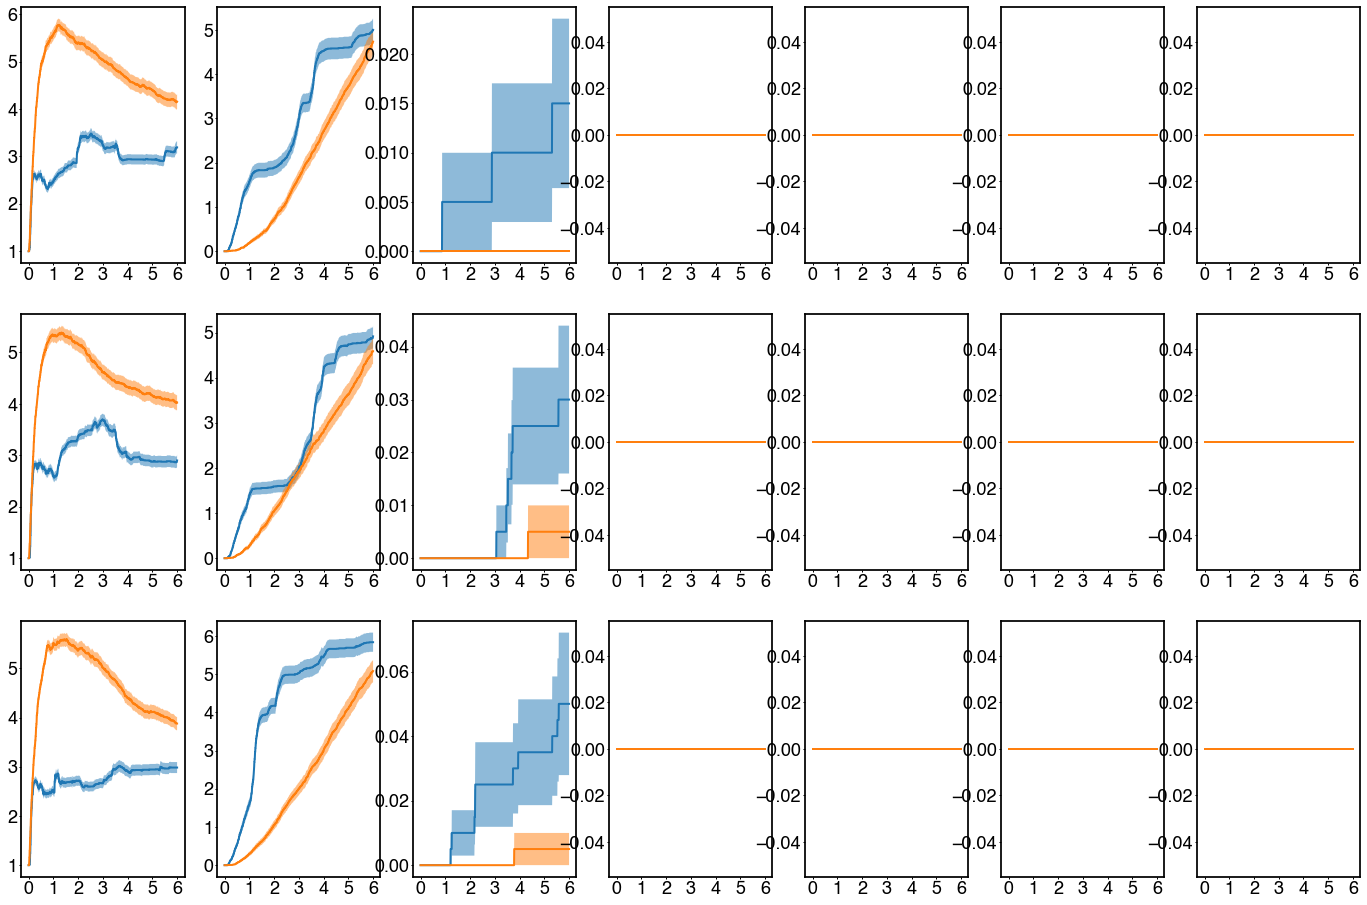

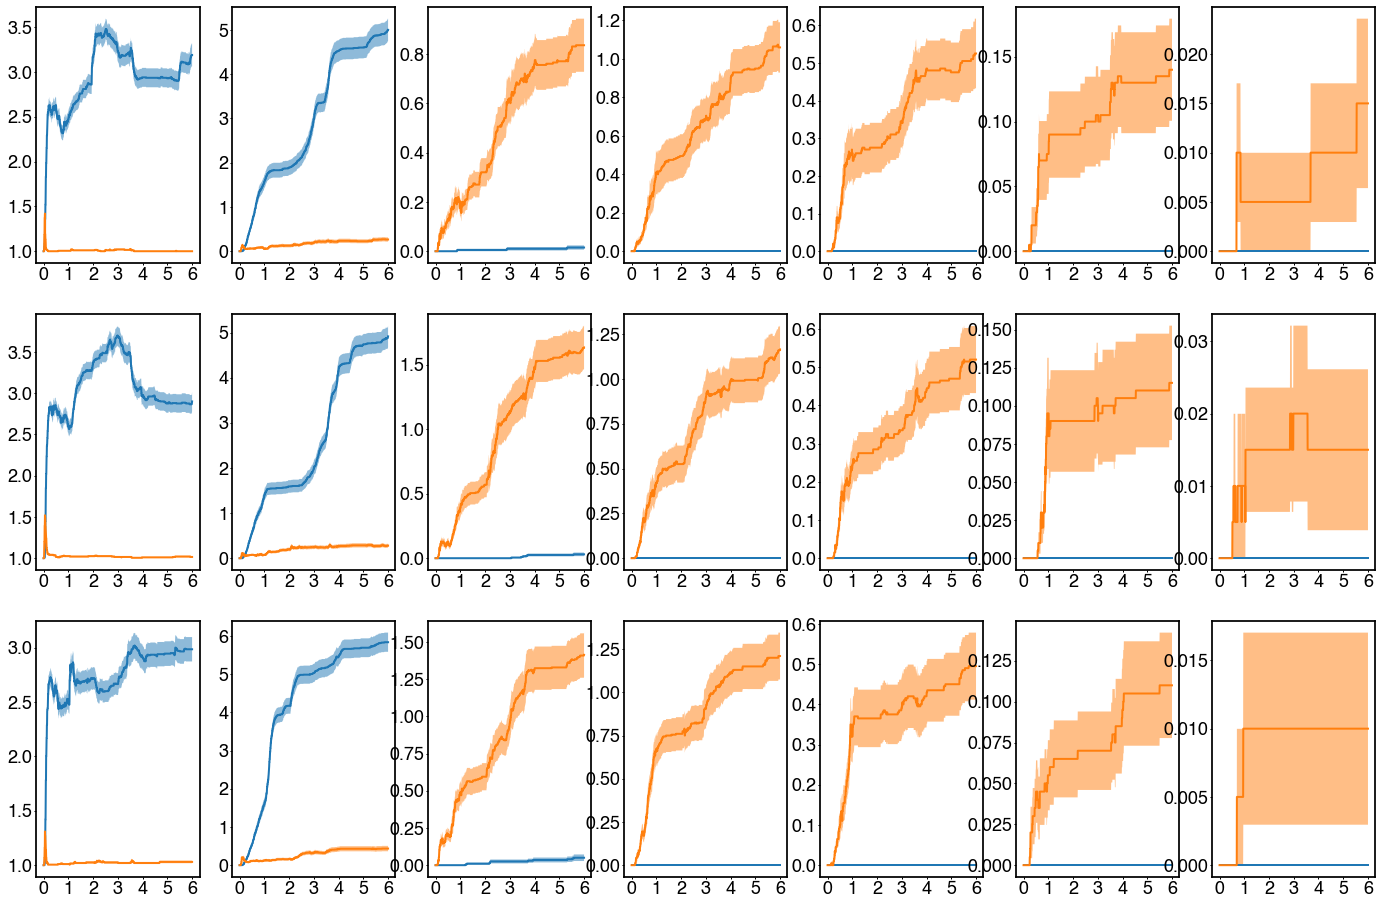

In [8]:
# curve_types = {'orig': bc, 'shuff': bcs, 'shuff-st': bcst, 'shuff-sts': bcsts, 'shuff-stss':bcstss, 'shuff-tme':bcstme}
# curve_names = {'orig': 'OriginalData', 'shuff': 'OriginalShuffle', 'shuff-st': 'ShuffleWithinStimAcrossTrials', 'shuff-sts': 'ShuffleAcrossStimAcrossTrials', 'shuff-stss': 'ShuffleAcrossStimAcrossTrials-PreserveCellSpiketrains'}
# shuffle_types = ['shuff', 'shuff-st', 'shuff-sts', 'shuff-stss']

curve_types = {'orig': bc, 'shuff': bcs, 'shuff-tme':bctme}
curve_names = {'orig': 'OriginalData', 'shuff': 'OriginalShuffle', 'shuff-st': 'ShuffleWithinStimAcrossTrials', 'shuff-sts': 'ShuffleAcrossStimAcrossTrials', 'shuff-stss': 'ShuffleAcrossStimAcrossTrials-PreserveCellSpiketrains',
               'shuff-tme': 'MaximumEntropyModel'}

shuffle_types = ['shuff', 'shuff-tme']
for shuffle_type in shuffle_types:

    # generate figure and axes
    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    figname=curve_names[shuffle_type]
    bettis = [0, 1, 2, 3,4,5,6]              # Betti number to plot
    maxbetti = np.amax(bettis)
    fig, axs = plt.subplots(3,maxbetti+1, figsize=(24, 16), sharey=False)
    axs = axs.flatten()


    stims = np.array(list(bc.keys()))  # Stimuli names
    stimIDs = [1, 2, 3]                # ID numbers of stimuli to plot
    stims_to_plot = stims[stimIDs]     # names of stimuli to plot

    # Compute the mean and stderr
    bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc)     # Real curves 
    bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(curve_types[shuffle_type])   # Shuffled curves 

    for betti in bettis:
        for ind, stim in enumerate(stims_to_plot):
            ax = axs[(maxbetti+1)*ind + betti]
            tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
            tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)

    #plt.savefig(os.path.join(figsavepth, '{}_P03S03_BettiCurveWithShuffled_betti{}_{}_alltogether.eps'.format(bird,betti, thresh)))
    plt.savefig(os.path.join(figsavepth, '{}_{}_{}_maxbetti-{}.pdf'.format(bird,figname, thresh, np.amax(bettis))))

## Plot all shuffles individually for each bird for all stims

In [ ]:
# All birds, All Stims, All shuffles, individually

curve_types = {'orig': bc, 'shuff': bcs, 'shuff-st': bcst, 'shuff-sts': bcsts, 'shuff-stss':bcstss}
curve_names = {'orig': 'OriginalData', 'bcs': 'OriginalShuffle', 'bcst': 'ShuffleWithinStimAcrossTrials', 'bcsts': 'ShuffleAcrossStimAcrossTrials', 'bcstss': 'ShuffleAcrossStimAcrossTrials-PreserveCellSpiketrains'}

shuffle_types = ['bcs', 'bcst', 'bcsts', 'bcstss']

for bird in birds:
    bird_betti_data = betti_data[bird]
    for shuffle_suffix in shuffle_types:

        # generate figure and axes
        plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
        figname=curve_names[shuffle_suffix]
        fig, axs = plt.subplots(4, 8, figsize=(32, 16), sharey=False)
        axs = axs.flatten()
        
        # Compute the mean and stderr
        bc = bird_betti_data['bc']
        bcs = bird_betti_data[shuffle_suffix]
        bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc)     # Real curves 
        bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 

        bettis = [0, 1, 2, 3]              # Betti number to plot
        stims = np.array(list(bc.keys()))  # Stimuli names
        stimIDs = range(8)                 # ID numbers of stimuli to plot
        stims_to_plot = stims[stimIDs]     # names of stimuli to plot
#         print('Bird stims: {}'.format(stims))
#         print('Plotting stims: {}'.format(stims_to_plot))

        t_ms = bird_betti_data['t_ms']
        for betti in bettis:
            for ind, stim in enumerate(stims_to_plot):
                ax = axs[len(stimIDs)*betti + ind]
                tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
                tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
        plt.savefig(os.path.join(figsavepth, '{}_{}_{}_allstim.pdf'.format(bird,figname, thresh)))

## Plot all shuffles on same plot, for Bettis 0-3 and Stims 1-3 for single bird

In [ ]:
# All the shuffles on the same plot, for 3 stimuli from single bird

curve_types = {'orig': bc, 'shuff': bcs, 'shuff-st': bcst, 'shuff-sts': bcsts, 'shuff-stss':bcstss}
curve_names = {'orig': 'OriginalData', 'bcs': 'OriginalShuffle', 'bcst': 'ShuffleWithinStimAcrossTrials', 'bcsts': 'ShuffleAcrossStimAcrossTrials', 'bcstss': 'ShuffleAcrossStimAcrossTrials-PreserveCellSpiketrains'}

shuffle_types = ['bcs', 'bcst', 'bcsts', 'bcstss']

bird = 'B1083'

bird_betti_data = betti_data[bird]
    # generate figure and axes
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharey=False)
axs = axs.flatten()
bc = bird_betti_data['bc']
bettis = [0, 1, 2, 3]              # Betti number to plot
stims = np.array(list(bc.keys()))  # Stimuli names
stimIDs = [1,2,3]                # ID numbers of stimuli to plot
stims_to_plot = stims[stimIDs]     # names of stimuli to plot
bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc) 
t_ms = bird_betti_data['t_ms']
for betti in bettis:
    for ind, stim in enumerate(stims_to_plot):
        ax = axs[len(bettis)*ind + betti]
        tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
for shuffle_suffix in shuffle_types:  
    bcs = bird_betti_data[shuffle_suffix]
    bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 
    for betti in bettis:
        for ind, stim in enumerate(stims_to_plot):
            ax = axs[4*ind + betti]
            tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
plt.legend(['bc'] + shuffle_types)
plt.savefig(os.path.join(figsavepth, '{}_{}_3stim_allshuff.pdf'.format(bird, thresh)))

## Plot all shuffles on same plot for all birds and all stimuli
### Produces Nbird plots, each of shape Nbetti x Nstims

In [ ]:
# All birds, All Stims, All shuffles, on same plot

curve_types = {'orig': bc, 'shuff': bcs, 'shuff-st': bcst, 'shuff-sts': bcsts, 'shuff-stss':bcstss}
curve_names = {'orig': 'OriginalData', 'bcs': 'OriginalShuffle', 'bcst': 'ShuffleWithinStimAcrossTrials', 'bcsts': 'ShuffleAcrossStimAcrossTrials', 'bcstss': 'ShuffleAcrossStimAcrossTrials-PreserveCellSpiketrains'}

shuffle_types = ['bcs', 'bcst', 'bcsts', 'bcstss']

for bird in birds:
    bird_betti_data = betti_data[bird]
        # generate figure and axes
    plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
    fig, axs = plt.subplots(4, 8, figsize=(32, 16), sharey=False)
    axs = axs.flatten()
    bc = bird_betti_data['bc']
    bettis = [0, 1, 2, 3]              # Betti number to plot
    stims = np.array(list(bc.keys()))  # Stimuli names
    stimIDs = range(8)                 # ID numbers of stimuli to plot
    stims_to_plot = stims[stimIDs]     # names of stimuli to plot
    bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bc) 
    t_ms = bird_betti_data['t_ms']
    for betti in bettis:
        for ind, stim in enumerate(stims_to_plot):
            ax = axs[len(stimIDs)*betti + ind]
            tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
    for shuffle_suffix in shuffle_types:  
        bcs = bird_betti_data[shuffle_suffix]
        bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bcs)   # Shuffled curves 
        for betti in bettis:
            for ind, stim in enumerate(stims_to_plot):
                ax = axs[len(stimIDs)*betti + ind]

                tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
        plt.savefig(os.path.join(figsavepth, '{}_{}_allstim_allshuff.pdf'.format(bird, thresh)))

In [ ]:
betti=4
plt.figure(figsize=(22, 11))
for stim in bc.keys():
    dat = bc[stim]
    avg = np.mean(dat, axis=2)
    avgs = np.mean(dats, axis=2)
    
    std = np.std(dat, axis=2)
    stds = np.std(dats, axis=2)
    
    stderr = std / np.sqrt(np.shape(dat)[2])
    stderrs = stds / np.sqrt(np.shape(dats)[2])
    
    y = avg[betti, :]
    ys = avgs[betti, :]
    
    s = stderr[betti, :]
    ss = stderrs[betti, :]
    plt.plot(t_ms/1000., y, linewidth=2.5)
    
    ax = plt.gca()
    ax.fill_between(t_ms/1000., y-s, y+s, alpha = 0.3)
    ax.tick_params(labelsize=20)
    ax.set_xticks(range(7))
    plt.plot(np.array([[x, x] for x in range(6)]).T, np.array([[0, np.amax(avg[betti, :])] for x in range(6)]).T, 'k--')
    
plt.savefig(os.path.join('/home/brad/DailyLog/20170814/', '{}_P03S03_BettiCurvesAllStim_betti{}.eps'.format(bird, betti)))

In [ ]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(22, 11))
bettis = [0,1,2,3]

axs = np.ravel(axs)
for ind, stim in enumerate(bc.keys()):
    dat = bc[stim]
    dats = bcs[stim]
    avg = np.mean(dat, axis=2)
    avgs = np.mean(dats, axis=2)
    
    std = np.std(dat, axis=2)
    stds = np.std(dats, axis=2)
    
    stderr = std / np.sqrt(np.shape(dat)[2])
    stderrs = stds / np.sqrt(np.shape(dats)[2])
    ax = axs[ind]
    for betti in bettis:
        y = avg[betti, :]
        ys = avgs[betti, :]
    
        s = stderr[betti, :]
        ss = stderrs[betti, :]
        ax.plot(t_ms/1000., y, linewidth=2.5)
        ax.fill_between(t_ms/1000., y-s, y+s, alpha = 0.3)
        ax.tick_params(labelsize=20)
        ax.set_xticks(range(7))
    #plt.plot(np.array([[x, x] for x in range(6)]).T, np.array([[0, np.amax(avg[betti, :])] for x in range(6)]).T, 'k--')

In [ ]:

betti = 0
fig, axs = plt.subplots(4,8, figsize=(44,22), sharey=False)
axs = axs.flatten()
for betti in range(4):
    #print(betti)
    for ind, stim in enumerate(bc.keys()):
        print(stim)
        dat = bc[stim]
        dats = bcs[stim]
        avg = np.mean(dat, axis=2)
        avgs = np.mean(dats, axis=2)
    
        std = np.std(dat, axis=2)
        stds = np.std(dats, axis=2)
    
        stderr = std / np.sqrt(np.shape(dat)[2])
        stderrs = stds / np.sqrt(np.shape(dats)[2])
    
        y = avg[betti, :]
        ys = avgs[betti, :]
    
        s = stderr[betti, :]
        ss = stderrs[betti, :]

        ax = axs[8*betti + ind]

        ax.plot(t_ms/1000, y,linewidth=2)
        ax.fill_between(t_ms/1000, y-s, y+s, alpha=0.5)
        ax.plot(t_ms/1000, ys, linewidth=2)
        ax.fill_between(t_ms/1000, ys-ss, ys+ss, alpha=0.5)
        ax.tick_params(labelsize=20)
        ax.set_xticks(range(7))
    
plt.savefig(os.path.join('/home/brad/DailyLog/20170829/', '{}_P03S03_BettiCurveWithShuffled_betti{}.eps'.format(bird,betti)))

# All bettis single stim

In [ ]:
fig = plt.figure(figsize=(20, 11))
ax = plt.gca()
bettis = [0,1,2,3]
stim = 'L_40k'
dat = bc[stim]
dats = bcs[stim]
avg = np.mean(dat, axis=2)
avgs = np.mean(dats, axis=2)

std = np.std(dat, axis=2)
stds = np.std(dats, axis=2)

stderr = std / np.sqrt(np.shape(dat)[2])
stderrs = stds / np.sqrt(np.shape(dats)[2])

for ind, betti in enumerate(bettis):

    y = avg[betti, :]
    ys = avgs[betti, :]
    
    s = stderr[betti, :]
    ss = stderrs[betti, :]
    ax.plot(t_ms/1000, y,linewidth=2)
    ax.fill_between(t_ms/1000, y-s, y+s, alpha=0.5)
    #ax.plot(t_ms/1000, ys, linewidth=2)
    #ax.fill_between(t_ms/1000, ys-ss, ys+ss, alpha=0.5)
    ax.tick_params(labelsize=36)
    ax.set_xticks(range(-2,9))
    ax.legend(['0', '1', '2', '3'], fontsize=36)
    #if betti == 3:
    #    ax.set_ylim([-0.1, 4])
ax.set_xlim([-2,8])
plt.savefig(os.path.join(figsavepth, '{}_P03S03_AllBettis_stim{}.pdf'.format(bird,stim)))

# Comparison between full population and subsets

In [ ]:
reload(tp2)

bird = 'B1056'
block_path = bps[bird]
bdf = bdfs[bird]

analysis_id = 'test2'
thresh = 4.0
nperms = None
ncellsperm = 0
dim = [0,1, 2,3,4]
Ntimes = 1000

windt = 10.0
dtovr = windt*0.5
stimlen = 6000 #ms
twin = np.linspace(0, stimlen, Ntimes)

(bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                         thresh, nperms, ncellsperm,
                                         dim, twin, windt, dtovr, shuffle=False)
#shuffle
(bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                            thresh, nperms, ncellsperm,
                                            dim, twin, windt, dtovr, shuffle=True)


nperms = 20
ncellsperm = 30
(bc_perm, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                         thresh, nperms, ncellsperm,
                                         dim, twin, windt, dtovr, shuffle=False)
#shuffle
(bcs_perm, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                            thresh, nperms, ncellsperm,
                                            dim, twin, windt, dtovr, shuffle=True)

In [ ]:

betti = 3
fig, axs = plt.subplots(4,4, figsize=(22,22), sharey=True)
axs = axs.flatten()
for ind, stim in enumerate(bc.keys()):
    dat = bc[stim]
    dats = bc_perm[stim]
    avg = np.mean(dat, axis=2)
    avgs = np.mean(dats, axis=2)
    
    std = np.std(dat, axis=2)
    stds = np.std(dats, axis=2)
    
    stderr = std / np.sqrt(np.shape(dat)[2])
    stderrs = stds / np.sqrt(np.shape(dats)[2])
    
    y = avg[betti, :]
    ys = avgs[betti, :]
    
    s = stderr[betti, :]
    ss = stderrs[betti, :]
    
    ax = axs[ind]
    ax.plot(t_ms/1000, y,linewidth=2)
    ax.fill_between(t_ms/1000, y-s, y+s, alpha=0.5)
    ax.plot(t_ms/1000, ys, linewidth=2)
    ax.fill_between(t_ms/1000, ys-ss, ys+ss, alpha=0.5)
    ax.tick_params(labelsize=20)
    ax.set_xticks(range(7))
    #if betti == 3:
     #   ax.set_ylim([-0.1, 4])
    
plt.savefig(os.path.join('/home/brad/DailyLog/20170829/', '{}_BettiCurveWithPermed{}-{}_betti{}.eps'.format(bird,ncellsperm, nperms,betti)))

# Comparison Across Birds

In [ ]:
# 4 birds, 4 Bettis, all stim on one chart 
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

#bin the data
winsize = 10.0
dtovr = winsize*0.5
comment = 'ForBettiCurves2'
segment_info = [0,0]
bdfs = {}

for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf


In [ ]:
#compute bettis:
bcurves = {}     # dictionary to store betti curves for each bird
bscurves = {}
dims = [0,1,2,3,4]
# Compute betti curves for each bird
for bird in birds:
    block_path = bps[bird]
    bdf = bdfs[bird]
    (bc, t, t_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                         thresh, nperms, ncellsperm,
                                         dims, twin, windt, dtovr, shuffle=False)
    # Compute the betti curves for shuffled-in-time data
    # This breaks the inter-neuronal coordination
    (bcs, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf,
                                            thresh, nperms, ncellsperm,
                                            dims, twin, windt, dtovr, shuffle=True)
    bcurves[bird] = bc
    bscurves[bird] = bcs

In [ ]:
# generate figure and axes



from importlib import reload
reload(tpplt)
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
fig, axs = plt.subplots(len(dims), len(birds), figsize=(8,6))
print(axs.shape)
axs = axs.flatten()



for ind1, bird in enumerate(birds):
    bc = bcurves[bird]      # pull betti curves from bird
    for ind2, betti in enumerate(dims):
        
        # pull stimuli to plot
        stims = list(bc.keys())
        stims_to_plot = stims[:8]
        
        # compute mean and stderr betti curves
        bc_bird = tp2.compute_mean_stderr_betti_curves(bc)
        
        # plot betti curve for each stimulus
        for ind, stim in enumerate(stims_to_plot):
            print(ind2*len(birds) + ind1)
            ax = axs[ind2*len(birds) + ind1]
            tpplt.plot_betti_curve(bc_bird, t_ms, stim, betti, ax, linewidth=1)
            for i in ax.get_xticklabels():
                i.set_fontsize(10)
                i.set_fontname('helvetica')
            for i in ax.get_yticklabels():
                i.set_fontsize(10)
                i.set_fontname('helvetica')

plt.subplots_adjust(wspace=0.4, hspace=0.35)
# Save figure
plt.savefig(os.path.join(figsavepth, 'AllBirdsAllBettisAllStim{}.pdf'.format(windt)))

# Sound Spike Betti Plot

In [ ]:
from ephys import core, events, rasters

bird = 'B1083'

bettis = [0,1,2,3]

block_path = bps[bird]
spikes     = core.load_spikes(block_path)
clusters   = core.load_clusters(block_path)
digmarks = events.load_events(block_path, 'DigMark')
fs         = core.load_fs(block_path)
trials     = events.load_trials(block_path)
rec        = 0 

In [ ]:
bc = bcurves[bird]
bc_bird = tp2.compute_mean_stderr_betti_curves(bc)

In [ ]:
from importlib import reload
reload(tpplt)

stim = 'N_40k'
trial = 1

plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
fig = plt.figure(figsize=(5,10))
ax_sound = fig.add_subplot(311)
ax_spikes = fig.add_subplot(312, sharex=ax_sound)
ax_bettis = fig.add_subplot(313, sharex=ax_sound)

# Plot sound
from scipy.signal import spectrogram
from scipy.io.wavfile import read
(rate, x) =read('/home/brad/krista_stims/{}.wav'.format(stim))
x = x / x.max()
freqs, spts, Sxx = spectrogram(x, rate, nperseg=512, nfft=512, noverlap=512-64, return_onesided=True, mode='psd')
freqs /= 1000.0
Sxx /= np.amax(Sxx)
Sxx = np.log10(Sxx)
nf, nt = np.shape(Sxx)
thresh = -np.inf
Sxx[Sxx< thresh] = thresh
ax_sound.imshow(Sxx, origin='lower', aspect='auto', extent=(0, spts[-1],0, freqs[-1]), cmap='hot', interpolation='bicubic')
ax_sound.set_ylim([0, freqs[-1]])


# plot spikes
clusters_to_plot = clusters[clusters['quality']=='Good']
rasters.plot_raster_stim_trial(spikes, trials, clusters_to_plot, stim, trial, [0, 0], rec, fs, ax=ax_spikes)
spylim = ax_spikes.get_ylim()
ax_spikes.set_yticks([1, 100])

# plot betti
orng = '#ff7f0e'
blu = '#1f77b4'
betticols = [orng, blu, blu, orng]
#first normalize the betti curves
for betti in bettis:
    tpplt.plot_normalized_betti_curve(bc_bird, t_ms, stim, betti, ax_bettis)


axs = [ax_sound, ax_spikes, ax_bettis]
for ax in axs:
    oldylim = ax.get_ylim()
    for sec in [1,2,3,4,5]:
        
        ax.plot([sec, sec], oldylim, 'k--', linewidth=2)
    ax.set_ylim(oldylim)

figpth = os.path.join(figsavepth, 'SoundSpikesBettis.pdf')
print(figpth)
plt.savefig(figpth)

In [ ]:

bird = 'B1083'

stims_to_plot = list(bcurves[bird].keys())[1:4]
# Plot real against shuffled for two stimuli
# This serves as a useful template for betti curve plottinggg
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
# Generate figure and axes
fig, axs = plt.subplots(3,3, figsize=(8,6), sharey=False)
axs = axs.flatten()

betti = 1                         # Betti number to plot
bettis = [0,1,2]
stims = np.array(list(bc.keys()))  # Stimuli names
#stimIDs = ['I_40k']                # ID numbers of stimuli to plot
#stims_to_plot = stims[stimIDs]     # names of stimuli to plot
#stims_to_plot = ['I_40k']
# Compute the mean and stderr
bc_plot_dict = tp2.compute_mean_stderr_betti_curves(bcurves[bird])     # Real curves 
bcs_plot_dict = tp2.compute_mean_stderr_betti_curves(bscurves[bird])   # Shuffled curves 

# Plot the curves
for bind, betti in enumerate(bettis):
    for ind, stim in enumerate(stims_to_plot):
        ax = axs[3*bind+ind]
        tpplt.plot_betti_curve(bc_plot_dict, t_ms, stim, betti, ax)
        tpplt.plot_betti_curve(bcs_plot_dict, t_ms, stim, betti, ax)
        for i in ax.get_xticklabels():
            i.set_fontsize(14)
            i.set_fontname('helvetica')
        for i in ax.get_yticklabels():
            i.set_fontsize(14)
            i.set_fontname('helvetica')
plt.subplots_adjust(wspace=0.3, hspace=0.35)
# Save the figure
plt.savefig(os.path.join(figsavepth, 'B1083shuffleplot1.pdf'))

In [ ]:
bstyle = ['-', '-.', '-', '-.']
for betti in [0, 3]:
    tpplt.plot_betti_curve(bc_bird, t_ms, stim, betti, ax_bettis, color=betticols[betti], linestyle=bstyle[betti])
ax_bettis.tick_params('y', colors=orng)
ax_bettis2 = ax_bettis.twinx()
ax_bettis2.tick_params('y', colors=blu)
for betti in [1, 2]:
    tpplt.plot_betti_curve(bc_bird, t_ms, stim, betti, ax_bettis2, color=betticols[betti], linestyle=bstyle[betti])
  

In [ ]:
stims

In [ ]:
from importlib import reload
reload(tpplt)

stim = 'L_40k'
trial = 1

plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
fig = plt.figure(figsize=(10,8))

# plot spikes
clusters_to_plot = clusters[clusters['quality']=='Good'][10:53]
rasters.plot_raster_stim_trial(spikes, trials, clusters_to_plot, stim, trial, [0, 0], rec, fs, ax=plt.gca())
spylim = plt.gca().get_ylim()
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

figpth = os.path.join(figsavepth, 'sptrain_stim{}_trial{}.pdf'.format(stim, trial))
print(figpth)
plt.savefig(figpth)

In [ ]:
# Plot sound
plt.figure()
ax_sound = plt.gca()
from scipy.signal import spectrogram
from scipy.io.wavfile import read
(rate, x) =read('/home/brad/krista_stims/{}.wav'.format(stim))
x = x / x.max()
freqs, spts, Sxx = spectrogram(x, rate, nperseg=512, nfft=512, noverlap=512-64, return_onesided=True, mode='psd')
freqs /= 1000.0
Sxx /= np.amax(Sxx)
Sxx = np.log10(Sxx)
nf, nt = np.shape(Sxx)
thresh = -np.inf
Sxx[Sxx< thresh] = thresh
ax_sound.imshow(Sxx, origin='lower', aspect='auto', extent=(0, spts[-1],0, freqs[-1]), cmap='hot', interpolation='bicubic')
ax_sound.set_ylim([0, freqs[-1]])
figpth = os.path.join(figsavepth, 'spgram.pdf'.format(stim, trial))
print(figpth)
plt.savefig(figpth)

In [ ]:
import h5py as h5
# compute poisson statistics
for bird in birds:
    bdf = bdfs[bird]
    with h5.File(bdf, "r") as bdff:
        stims = bdff.keys()
        for stim in stims:
            poptens = np.array(bdff[stim]["pop_tens"])
            nwin = poptens.shape[1]
            rate = np.mean(poptens, axis=(1,2))
            print(poptens.shape, rate)